In [15]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit,types,typeof
from numba.experimental import jitclass
import pandas as pd
style_file = '/home/monal/setup/mpl_plotting/thesis.mplstyle'
plt.style.use(style_file)

import sys
sys.setrecursionlimit(10000)

array   = np.ndarray
real    = np.float64
integer = np.int64

alpha_small = 1e-6

## Linear Algebra

In [16]:
# adaptated from https://www.geometrictools.com/GTE/Mathematics/SymmetricEigensolver3x3.h> 
thresh = 1e-8
@njit
def NISymmetricEigensolver3x3(A: array, evals: array, evec: array) -> None:
  # Precondition the matrix by factoring out the maximum absolute value of the components.
  a00 = A[0,0]
  a01 = A[0,1]
  a02 = A[0,2]
  a10 = A[1,0]
  a11 = A[1,1]
  a12 = A[1,2]
  a20 = A[2,0]
  a21 = A[2,1]
  a22 = A[2,2]
  
  max0 = max(abs(a00), abs(a01))
  max1 = max(abs(a02), abs(a11))
  max2 = max(abs(a12), abs(a22))
  maxAbsElement = max(max0, max1, max2)
  
  if maxAbsElement < thresh:
    # A is the zero matrix.
    evals[:] = 0
    evec[0] = np.array([1, 0, 0])
    evec[1] = np.array([0, 1, 0])
    evec[2] = np.array([0, 0, 1])
  else: 
    invMaxAbsElement = 1 / maxAbsElement
    a00 *= invMaxAbsElement
    a01 *= invMaxAbsElement
    a02 *= invMaxAbsElement
    a11 *= invMaxAbsElement
    a12 *= invMaxAbsElement
    a22 *= invMaxAbsElement
    
    norm = a01 * a01 + a02 * a02 + a12 * a12
    if norm > thresh:
      q = (a00 + a11 + a22) / 3
      b00 = a00 - q
      b11 = a11 - q
      b22 = a22 - q
      p = np.sqrt((b00 * b00 + b11 * b11 + b22 * b22 + 2 * norm) / 6)
      c00 = b11 * b22 - a12 * a12
      c01 = a01 * b22 - a12 * a02
      c02 = a01 * a12 - b11 * a02
      det = (b00 * c00 - a01 * c01 + a02 * c02) / (p * p * p)
      halfDet = det * real(0.5)
      halfDet = np.min(np.array([np.max(np.array([halfDet, -1.])), 1.]))
      angle = np.arccos(halfDet) / 3
      twoThirdsPi = 2*np.pi/3
      beta2 = 2 * np.cos(angle)
      beta0 = 2 * np.cos(angle + twoThirdsPi)
      beta1 = -(beta0 + beta2)
      evals[0] = q + p * beta0
      evals[1] = q + p * beta1
      evals[2] = q + p * beta2
      
      if halfDet >= thresh:
        compute_eigenvector0(a00, a01, a02, a11, a12, a22, evals[2], evec[2])
        compute_eigenvector1(a00, a01, a02, a11, a12, a22, evec[2], evals[1], evec[1])
        evec[0] = np.cross(evec[1], evec[2])
      else:
        compute_eigenvector0(a00, a01, a02, a11, a12, a22, evals[0], evec[0])
        compute_eigenvector1(a00, a01, a02, a11, a12, a22, evec[0], evals[1], evec[1])
        evec[2] = np.cross(evec[0], evec[1])
    else:
      # A is diagonal.
      evals[0] = a00
      evals[1] = a11
      evals[2] = a22
      evec[0] = [1, 0, 0]
      evec[1] = [0, 1, 0]
      evec[2] = [0, 0, 1]
    
    evals[:] *= maxAbsElement
    sort_eigenstuff(evals, evec)
    evec[:] = evec.T

@njit
def compute_eigenvector0(a00: real, a01: real, a02: real, a11: real, a12: real, a22: real, eval0: array, evec0: array) -> None:
  row0 = np.array([a00 - eval0, a01, a02])
  row1 = np.array([a01, a11 - eval0, a12])
  row2 = np.array([a02, a12, a22 - eval0])
  r0xr1 = np.cross(row0, row1)
  r0xr2 = np.cross(row0, row2)
  r1xr2 = np.cross(row1, row2)
  d0 = np.dot(r0xr1, r0xr1)
  d1 = np.dot(r0xr2, r0xr2)
  d2 = np.dot(r1xr2, r1xr2)
  dmax = d0
  imax = 0
  if d1 > dmax:
    dmax = d1
    imax = 1
  if d2 > dmax:
    imax = 2
  if imax == 0:
    evec0[:] = r0xr1 / np.sqrt(d0)
  elif imax == 1:
    evec0[:] = r0xr2 / np.sqrt(d1)
  else:
    evec0[:] = r1xr2 / np.sqrt(d2)

@njit
def compute_eigenvector1(a00: real, a01: real, a02: real, a11: real, a12: real, a22: real, evec0: array, eval1: array, evec1: array) -> None:
  U, V = compute_orthogonal_complement(evec0)
  AU = np.array([a00 * U[0] + a01 * U[1] + a02 * U[2],
           a01 * U[0] + a11 * U[1] + a12 * U[2],
           a02 * U[0] + a12 * U[1] + a22 * U[2]])
  AV = np.array([a00 * V[0] + a01 * V[1] + a02 * V[2],
           a01 * V[0] + a11 * V[1] + a12 * V[2],
           a02 * V[0] + a12 * V[1] + a22 * V[2]])
  m00 = np.dot(U, AU) - eval1
  m01 = np.dot(U, AV)
  m11 = np.dot(V, AV) - eval1
  absM00 = abs(m00)
  absM01 = abs(m01)
  absM11 = abs(m11)
  if absM00 >= absM11:
    maxAbsComp = max(absM00, absM01)
    if maxAbsComp > 0:
      if absM00 >= absM01:
        m01 /= m00
        m00 = 1 / np.sqrt(1 + m01 * m01)
        m01 *= m00
      else:
        m00 /= m01
        m01 = 1 / np.sqrt(1 + m00 * m00)
        m00 *= m01
      evec1[:] = m01 * U - m00 * V
    else:
      evec1[:] = U
  else:
    maxAbsComp = max(absM11, absM01)
    if maxAbsComp > 0:
      if absM11 >= absM01:
        m01 /= m11
        m11 = 1 / np.sqrt(1 + m01 * m01)
        m01 *= m11
      else:
        m11 /= m01
        m01 = 1 / np.sqrt(1 + m11 * m11)
        m11 *= m01
      evec1[:] = m11 * U - m01 * V
    else:
      evec1[:] = U

@njit
def compute_orthogonal_complement(W: array) -> (array,array):
  if abs(W[0]) > abs(W[1]):
    invLength = 1 / np.sqrt(W[0] * W[0] + W[2] * W[2])
    U = np.array([-W[2] * invLength, 0, W[0] * invLength])
  else:
    invLength = 1 / np.sqrt(W[1] * W[1] + W[2] * W[2])
    U = np.array([0, W[2] * invLength, -W[1] * invLength])
  V = np.cross(W, U)
  return U, V

@njit
def sort_eigenstuff(evals: array, evec: array):
  idx = np.argsort(evals)
  evals[:] = evals[idx]
  evec[:] = evec[idx]
  
@njit
def inverse_3x3(M):
    det = (M[0, 0] * (M[1, 1] * M[2, 2] - M[2, 1] * M[1, 2]) -
         M[0, 1] * (M[1, 0] * M[2, 2] - M[1, 2] * M[2, 0]) +
         M[0, 2] * (M[1, 0] * M[2, 1] - M[1, 1] * M[2, 0]))

    if abs(det) < 1e-10:
      print("Singular matrix, determinant is zero in inverse_3x3")
      print(M)
      # print("Matrix: {M[0, 0]:.6e} {M[0, 1]:.6e} {M[0, 2]:.6e}")
      # print("        {M[1, 0]:.6e} {M[1, 1]:.6e} {M[1, 2]:.6e}")
      # print("        {M[2, 0]:.6e} {M[2, 1]:.6e} {M[2, 2]:.6e}")
      # print("\n")

    invdet = 1.0 / det

    Minv = np.zeros((3, 3))
    Minv[0, 0] = (M[1, 1] * M[2, 2] - M[2, 1] * M[1, 2]) * invdet
    Minv[0, 1] = (M[0, 2] * M[2, 1] - M[0, 1] * M[2, 2]) * invdet
    Minv[0, 2] = (M[0, 1] * M[1, 2] - M[0, 2] * M[1, 1]) * invdet
    Minv[1, 0] = (M[1, 2] * M[2, 0] - M[1, 0] * M[2, 2]) * invdet
    Minv[1, 1] = (M[0, 0] * M[2, 2] - M[0, 2] * M[2, 0]) * invdet
    Minv[1, 2] = (M[1, 0] * M[0, 2] - M[0, 0] * M[1, 2]) * invdet
    Minv[2, 0] = (M[1, 0] * M[2, 1] - M[2, 0] * M[1, 1]) * invdet
    Minv[2, 1] = (M[2, 0] * M[0, 1] - M[0, 0] * M[2, 1]) * invdet
    Minv[2, 2] = (M[0, 0] * M[1, 1] - M[1, 0] * M[0, 1]) * invdet

    return Minv
  
@njit
def sqrt_matrix(mat: array) -> array:
    evalues = np.zeros(3,dtype=real)
    evectors = np.zeros_like(mat)
    NISymmetricEigensolver3x3(mat,evalues,evectors)
    # Ensuring square root matrix exists
    assert (evalues >= 0).all()
    if not np.all(np.isreal(evalues)):
          raise AssertionError("The matrix has complex eigenvalues: ",evalues)
    L = np.identity(3)*np.sqrt(evalues)  
    # evalues, evectors = np.linalg.eigh(mat)
    # if not np.all(np.isreal(evalues)):
    #       raise AssertionError(f"The matrix has complex eigenvalues: {evalues}")
    # L = np.eye(3)*np.sqrt(evalues)

    return evectors @ L @ inverse_3x3(evectors)
    # return evectors @ L @ np.linalg.inv(evectors)

@njit
def log_matrix(mat: array) -> array:  
    evalues = np.zeros(3,dtype=real)
    evectors = np.zeros_like(mat)
    NISymmetricEigensolver3x3(mat,evalues,evectors)
    # Ensuring log root matrix exists
    assert (evalues >= 0).all()
    if not np.all(np.isreal(evalues)):
          raise AssertionError("The matrix has complex eigenvalues:", evalues)
    L = np.identity(3)*np.log(evalues)
    
    # evalues, evectors = np.linalg.eigh(mat)    
    # # Ensuring log root matrix exists
    # assert (evalues >= 0).all()
    # if not np.all(np.isreal(evalues)):
    #       raise AssertionError(f"The matrix has complex eigenvalues: {evalues}")
    # L = np.eye(3)*np.log(evalues)

#     print("log_matrix, evalues:",evalues, end="\n")
#     print("log_matrix, evectors:",evectors)
#     print("log_matrix, evectors_inv",np.linalg.inv(evectors))
    
#     print("log_matrix, V@L@Vinv:",evectors @ L @ np.linalg.inv(evectors))
    return evectors @ L @ inverse_3x3(evectors)
    # return evectors @ L @ np.linalg.inv(evectors)


In [17]:
### Tests

## Closures

In [45]:
spec = [('isFluid', types.boolean[:]),
        ('Gamma0', types.float64[:]),('e0', types.float64[:]),('p0', types.float64[:]),('G0', types.float64[:]),('K0', types.float64[:]),
        ('rho0', types.float64[:]),('C1', types.float64[:]), ('C2', types.float64[:]), ('sigmaY', types.float64[:]),
        ('nlin', types.int64),('nmat', types.int64),('ndim', types.int64),('nvar', types.int64),
        ('imass',types.int64),('imom', types.int64),('ienergy', types.int64),('ialpha', types.int64),('istretch', types.int64),('iplastic', types.int64)]
@jitclass(spec)
class closures:
  def __init__(self, isFluid, Gamma0, e0, p0, G0, K0, rho0, C1, C2, sigmaY):
    self.isFluid = isFluid
      
    self.nmat = Gamma0.shape[0]
    self.nlin= np.int64(7) #+ 2*self.nmat(3)
    self.ndim = np.int64(3)
    self.nvar = self.nmat + self.ndim + 1 + self.nmat-1 + self.ndim*self.ndim
    self.imass = np.int64(0)
    self.imom  = self.imass + self.nmat
    self.ienergy  = self.imom + self.ndim
    self.ialpha   = self.ienergy + 1
    self.istretch = self.ialpha + self.nmat - 1
    self.iplastic = self.istretch + self.ndim*self.ndim
    
    self.Gamma0 = Gamma0 # mie-grunesien parameter
    self.e0  = e0
    self.p0  = p0
    self.K0  = K0 # bulk modulus
    self.G0  = G0 # Shear modulus
    self.rho0 = rho0 # reference density
    self.C1  = C1 # compression energy exponent (alpha from wallis)
    self.C2  = C2 # Bulk modulus exponent (beta from wallis)
    self.sigmaY = sigmaY
   
  def Gl(self, rho: array) -> array:
    shear_modulus = np.zeros_like(rho)
    for i in range(self.nmat):
      if (self.isFluid[i]):
        shear_modulus[i] = 0.0
      else:
        shear_modulus[i] = self.G0[i]*(rho[i]/self.rho0[i])**(self.C2[i]+1)
        # shear_modulus[i] = 10e9 #self.G0[i]*(self.rho0[i]/self.rho0[i])**(self.C2[i]+1)
    return shear_modulus
  
  def Gmix(self, alpha: array, rho: array) -> real:
    one_over_Gamma0 = real(1.)/self.Gamma0
    temp = np.sum(alpha*self.Gl(rho)*one_over_Gamma0)/np.dot(alpha,one_over_Gamma0) # Note: Gamma0 is the Gruneisen parameter.
    return temp
  
  def Xmix(self, alpha: array, frobenius_norm_sigma: real) -> real:
    chi = self.Xl(frobenius_norm_sigma)
    one_over_Gamma0 = 1.0/self.Gamma0
    temp = np.sum(alpha*chi*one_over_Gamma0)/ np.dot(alpha,one_over_Gamma0)
    return temp
  
  def Xl(self, frobenius_norm_sigma: real) -> array:
    chi = 1e50*np.ones(self.nmat,dtype=real)
    for i in range(self.nmat):
      if (self.isFluid[i]):
        chi[i] = 0.0
      else:
        sigma = np.sqrt(1.5)*frobenius_norm_sigma
        if (sigma > self.sigmaY[i]):
          chi[i] = sigma - self.sigmaY[i]
    return chi
  
  def eref(self, rho: array, devH: array) -> array:
    ec = np.zeros_like(rho)
    es = np.zeros_like(rho)
    temp = np.trace(devH@devH.transpose())
    
    for i in range(self.nmat):
      if (self.isFluid[i]):
        ec[i] = self.e0[i]
        es[i] = 0.0
      else:
        ec[i] =  (self.K0[i]/(2*self.rho0[i]*self.C1[i]**2))*((rho[i]/self.rho0[i])**self.C1[i] - real(1))**2
        es[i] = (self.Gl(rho)[i]/rho[i])*temp
    
    return es + ec
  
  def pref(self, rho: array, devH: array) -> array:
    pref = np.zeros_like(rho)
    drho = np.zeros_like(rho)
    for i in range(self.nmat):
      if (self.isFluid[i]):
        pref[i] = self.p0[i]
      else:      
        drho[:] = 0.0
        delta = rho[i]/100
        drho[i] = delta
        rr = rho + drho
        ll = rho - drho
        pr = self.eref(rr,devH)[i]
        pl = self.eref(ll,devH)[i]
        pref[i] = rho[i]**2*(pr-pl)/(2*delta)
    return pref
  
  def deref_drho(self, rho: array, devH: array) :
    derivative = np.zeros_like(rho)
    drho = np.zeros_like(rho)
    
    for i in range(self.nmat):     
      drho[:] = 0.0
      delta = rho[i]/100
      drho[i] = delta
      rr = rho + drho
      ll = rho - drho
      er = self.eref(rr,devH)[i]
      el = self.eref(ll,devH)[i]
      derivative[i] = (er-el)/(2*delta)
    return derivative
    
  def dpref_drho(self, rho: array, devH: array) :
    derivative = np.zeros_like(rho)
    drho = np.zeros_like(rho)
    for i in range(self.nmat):     
      drho[:] = 0.0
      delta = rho[i]/100
      drho[i] = delta
      rr = rho + drho
      ll = rho - drho
      pr = self.pref(rr,devH)[i]
      pl = self.pref(ll,devH)[i]
      derivative[i] = (pr-pl)/(2*delta)
    return derivative
  
@njit
def get_unflatten_stretch(Vi: array, cls: closures) -> array:
  Ve = np.zeros((cls.ndim,cls.ndim),dtype=real)
  for i in range(cls.ndim):
    for j in range(cls.ndim):
      Ve[i,j] =  Vi[cls.istretch + cls.ndim*i + j]
  return Ve

@njit
def flatten_stretch(Vi: array, cls: closures) -> array:
  Ve = np.zeros(cls.ndim*cls.ndim,dtype=real)
  for i in range(cls.ndim):
    for j in range(cls.ndim):
      Ve[cls.ndim*i + j] =  Vi[i,j]
  return Ve

@njit
def get_alphas(V_or_Q: array, cls: closures) -> (array):
  alpha = np.zeros(cls.nmat,dtype=real)
  alpha[:cls.nmat-1] = V_or_Q[cls.ialpha:cls.istretch]
  alpha = np.clip(alpha,a_min=alpha_small,a_max=1.0-alpha_small)
  alpha[-1] = real(1.0) - np.sum(alpha[:-1])
  return alpha  

@njit
def ensure_symm_uni_modular_stretch_tensor(Q: array, cls: closures) -> array:
  Ve = np.zeros((cls.ndim,cls.ndim),dtype=real)
  
  for ii in range(Q.shape[0]):
    Ve = np.zeros((cls.ndim,cls.ndim),dtype=real)
    for i in range(cls.ndim):
      for j in range(cls.ndim):
        Ve[i,j] =  Q[ii, cls.istretch + cls.ndim*i + j]
    Ve = sqrt_matrix(Ve@Ve.transpose())
    
    for i in range(cls.ndim):
      for j in range(cls.ndim):
        Q[ii, cls.istretch + cls.ndim*i + j] = Ve[i,j]
    
  return Q

In [55]:
#        1      2     3       4    5   6   7    8   9   10   11   12   13  14   15   16   17   18  19
# Q = [αs.ρs, αl.ρl, αg.ρg, ρ.u, ρ.v, ρ.w, ρE, αs, αl, V11, V21, V31, V21, V22, V23, V31, V32, V33, εs ]
# V = [ρs   , ρl   , ρg   , u  , v  ,   w,  p, αs, αl, V11, V21, V31, V21, V22, V23, V31, V32, V33, εs]

@njit
def Fe2Ve(Fe: array) -> array:
  Ve = sqrt_matrix(Fe@(Fe.transpose()))
  det = np.linalg.det(Fe)
  return (det**(-1/3))*Ve

def Bi(Qi: array, cls:closures) -> array:
  idir = 0
  
  # extract key variables
  alpha = np.zeros(cls.nmat,dtype=real)
  alpha[:cls.nmat-1] = Qi[cls.ialpha:cls.istretch]
  alpha[-1] = real(1.0) - np.sum(alpha[:-1])
  rho_mix = np.sum(Qi[cls.imass:cls.imom])
  
  u   = Qi[cls.imom:cls.ienergy]/rho_mix
  # p   = Qi[cls.ienergy]
  # rho = Vi[cls.imass:cls.imom]  
  Ve  = Qi[cls.istretch:cls.iplastic]
  
  
  
  Bi = np.zeros((cls.nvar,cls.nvar),dtype=real)
  
  # volume fraction non-conservative term---------------
  for i in range(cls.nmat-1):
    Bi[cls.ialpha + i,cls.imom+idir] = -alpha[i]/rho_mix
    for j in range(cls.nmat):
      Bi[cls.ialpha + i,j] = u[idir]*alpha[i]/rho_mix

  # for i in range(cls.nmat-1):
  #   Bi[cls.ialpha+i, cls.ialpha+i] = u[idir]

  # strain tensor non-conservative term----------------
  for i in range(cls.ndim):
    for j in range(cls.ndim):
      ij  = cls.ndim*i + j

      Bi[cls.istretch + ij,cls.istretch + cls.ndim*idir + j] = u[i] # coefficient of strain tensor component derivative
      Bi[cls.istretch + ij,cls.imom+idir] = -(real(2.)/3)*(Ve[ij]/rho_mix) # coefficient of momentum derivative
      Bi[cls.istretch + ij,cls.imass:cls.imom] = (real(2.)/3)*(Ve[ij]/rho_mix)*u[idir] # coefficient of mass derivative     
      
      # kj  = cls.ndim*idir + j
#       Bi[cls.istretch + ij,cls.imom+i] = -Ve[kj]/rho_mix # coefficient of momentum derivative
#       Bi[cls.istretch + ij,cls.imass:cls.imom] = u[i]*Ve[kj]/rho_mix # coefficient of mass derivative 
      
#       Bi[cls.istretch + ij,cls.imom+idir] += -(real(2.)/3)*(Ve[ij]/rho_mix) # coefficient of momentum derivative
#       Bi[cls.istretch + ij,cls.imass:cls.imom] += (real(2.)/3)*(Ve[ij]/rho_mix)*u[idir] # coefficient of mass derivative  
  return Bi

@njit
def Si(Qim1: array, Qi: array, Qip1: array, VL: array, VR: array, cls:closures) -> array:
  idir = 0
  
  
  # extract key variables
  alpha = np.zeros(cls.nmat,dtype=real)
  alpha[:cls.nmat-1] = Qi[cls.ialpha:cls.istretch]
  alpha[-1] = real(1.0) - np.sum(alpha[:-1])
  if (sum(alpha)>1.0): print("sum alpha > 1")
  rho_mix = np.sum(Qi[cls.imass:cls.imom])
  rhos = Qi[cls.imass:cls.imom]/alpha
  u   = Qi[cls.imom:cls.ienergy]/rho_mix
 
  source = np.zeros(cls.nvar,dtype=real)
  # volume fraction non-conservative term--------------- 
  for i in range(cls.nmat-1):
    source[cls.ialpha + i] = alpha[i]*(VR[cls.imom + idir] - VL[cls.imom + idir])
    # using contact velocity
    # source[cls.ialpha + i] = alpha[i]*(Qip1[cls.imom + idir]/np.sum(Qip1[cls.imass:cls.imom]) - Qim1[cls.imom + idir]/np.sum(Qip1[cls.imass:cls.imom]) )*0.5

  # strain tensor non-conservative term----------------
  term1 = np.zeros_like(source)
  term2 = np.zeros_like(source)
  for a in range(cls.ndim):
    for b in range(cls.ndim):
      ab  = cls.ndim*a    + b
      
      div = (VR[cls.imom + 0]-VL[cls.imom + 0]) #+ (VR[cls.imom + 1]-VL[cls.imom + 1]) + VR[cls.imom + 2]-VL[cls.imom + 2]
      beta = (VR[cls.istretch + cls.ndim*0 + b] - VL[cls.istretch + cls.ndim*0 + b]) #+ (VR[cls.istretch + cls.ndim*1 + b] - VL[cls.istretch + cls.ndim*1 + b]) + (VR[cls.istretch + cls.ndim*2 + b] - VL[cls.istretch + cls.ndim*2 + b])
      
      # div = (Qip1[cls.imom + idir]/np.sum(Qip1[cls.imass:cls.imom]) - Qim1[cls.imom + idir]/np.sum(Qip1[cls.imass:cls.imom]) )*0.5
      # beta = (Qip1[cls.istretch + cls.ndim*0 + b] - Qim1[cls.istretch + cls.ndim*0 + b])
      
      source[cls.istretch + ab] =  (real(2.)/3)*Qi[cls.istretch + ab]*div - u[a]*beta
      
  # plasticity-----------------------------------------
  # print("before plastic")
  # print("Qi",Qi)
  # Ve = Qi[cls.istretch:cls.iplastic]
  # print("Ve before flatten",Ve)
  
  Gmix = cls.Gmix(alpha,rhos)
  Ve = get_unflatten_stretch(Qi, cls)
  devH = log_matrix(Ve)
  fnorm_devH = np.sqrt(np.trace(devH@devH.T)) + 1e-8
  
  devSigma = 2*Gmix*devH
  f2norm_sigma = np.trace(devSigma@devSigma.T) + 1e-8
  # print("before Xmix")
  chi_mix = cls.Xmix(alpha,f2norm_sigma)
  
  numerator = devH@Ve
  
  
  tau = chi_mix*np.sqrt(1.5)/fnorm_devH
  # print(tau,fnorm_devH)
  for i in range(cls.ndim):
    for j in range(cls.ndim):
      source[cls.istretch + cls.ndim*i + j] -= numerator[i,j]/tau

#   # print("here")
  
  return source

@njit
def Fi(Qi: array,cls:closures) -> array:
  Vi = Q2V(Qi, cls)
  idir = 0
  
  # extract key variables
  alpha = np.zeros(cls.nmat,dtype=real)
  alpha[:cls.nmat-1] = Vi[cls.ialpha:cls.istretch]
  alpha[-1] = real(1.0) - np.sum(alpha[:-1])
  # rho_mix = np.sum(Qi[cls.imass:cls.imom])
  
  u   = Vi[cls.imom:cls.ienergy]
  p   = Vi[cls.ienergy]
  rho = Vi[cls.imass:cls.imom]
  # Ve = np.reshape(Vi[cls.istretch:cls.iplastic],(cls.ndim,cls.ndim),order='C')
  Ve = np.zeros((cls.ndim,cls.ndim),dtype=real)
  for i in range(cls.ndim):
    for j in range(cls.ndim):
      Ve[i,j] =  Vi[cls.istretch + cls.ndim*i + j]
    
  sig = sigma(p,alpha,rho,Ve,cls) #-p*np.identity(cls.ndim) + 2.*Gmix*devH
  
  # compute flux vector
  Fi = np.zeros(cls.nvar,dtype=real)
  # mass
  Fi[cls.imass:cls.imom] = Qi[cls.imass:cls.imom]*u[idir]
  # momentum
  Fi[cls.imom:cls.ienergy] = Qi[cls.imom:cls.ienergy]*u[idir] - sig[:,idir]
  # energy
  Fi[cls.ienergy] = Qi[cls.ienergy]*u[idir] - np.dot(u,sig[:,idir])
  # volume fraction
  Fi[cls.ialpha:cls.istretch] = alpha[:-1]*u[idir]
  
  # stretch tensor
  for i in range(cls.ndim):
    for j in range(cls.ndim):
      Fi[cls.istretch + cls.ndim*i + j] = Ve[i,j]*u[idir] - Ve[idir,j]*u[i]
      
  # print(Fi)
  return Fi

@njit
def sigma(p: real, alpha: array, rho: array, Ve: array, cls:closures) -> array:
  one_over_Gamma0 = real(1.)/cls.Gamma0
  Gmix = np.sum(alpha*cls.Gl(rho)*one_over_Gamma0)/np.dot(alpha,one_over_Gamma0) # Note: Gamma0 is the Gruneisen parameter.
  # Ve = np.clip(Ve,a_min=1e-12,a_max=None)
  devH = log_matrix(Ve)
  sigma = -p*np.identity(cls.ndim) + 2.*Gmix*devH
  return sigma

@njit 
def internal_energy(devH: array ,alpha:array, rho:array, p:real, cls:closures) -> real:
  
  if (np.any(rho<0.0)):
    raise UserWarning("Negative rho in internal energy")
  
  #----------------
#   eref = np.array(cls.nmat,dtype=real)
  
#   # eref
  
  
#   # solid
#   Gam = cls.Gamma[0]*(rho/cls.rho_ref)**(cls.beta+1)
#   norm = np.linalg.norm(devH, 'fro')
#   es = (Gam/rho[0])*norm*norm
#   ec = 0.0 # K0 /(alpha[0]**2) * (rho[0]*)  #K0  bulk modulus, G0 is shear modulus.
  
#   # liquid
#   eref[1] = cls.einf[1]
  
#   # gas
#   eref[2] = 0.0
  #------------------------------
  
  # phase energy mie-grunesen
  rhoe = (p - cls.pref(rho,devH))/(cls.Gamma0) + cls.eref(rho,devH)*rho
  # print("rhoe",rhoe)
  # print("pref",cls.pref(rho,devH))
  # print("Gamma0",cls.Gamma0)
  # print("eref",cls.eref(rho,devH))
  
  
  return np.dot(alpha,rhoe)

@njit
def pressure(devH: array ,alpha:array, rho:array, Eint: real, cls:closures) -> real:
  one_over_Gamma0 = real(1.0)/cls.Gamma0
  p = (Eint - np.sum(alpha*(cls.eref(rho,devH)*rho - cls.pref(rho,devH)*one_over_Gamma0)))/np.dot(alpha,one_over_Gamma0)
  return p 

@njit
def Q2V(Qi: array, cls:closures) -> array: 
  alpha = np.zeros(cls.nmat,dtype=real)
  alpha[:cls.nmat-1] = Qi[cls.ialpha: cls.istretch]
  alpha = np.clip(alpha,a_min=alpha_small,a_max=1.0-alpha_small)
  alpha[-1] = real(1.0) - np.sum(alpha[:-1])
  
  # 
  arho = Qi[cls.imass:cls.imom]
  rho = arho/alpha
  rho_mix = np.sum(arho)
  u       = Qi[cls.imom:cls.ienergy]/rho_mix
  
  norm = np.linalg.norm(u)
  Eint = Qi[cls.ienergy] - real(0.5)*rho_mix*norm*norm
  
  Ve = np.zeros((cls.ndim,cls.ndim),dtype=real)
  for i in range(cls.ndim):
    for j in range(cls.ndim):
      Ve[i,j] =  Qi[cls.istretch + cls.ndim*i + j]
  # Ve = np.clip(Ve,a_min=1e-12,a_max=None)
  # Ve = np.reshape(Qi[cls.istretch:cls.iplastic],(cls.ndim,cls.ndim),order='C')
  devH = log_matrix(Ve)
  
  # primtive variable array
  Vi = np.zeros_like(Qi,dtype=real)
  Vi[cls.imass:cls.imom] = rho[:]
  Vi[cls.imom:cls.ienergy] = u[:]
  Vi[cls.ienergy] = pressure(devH,alpha,rho,Eint,cls)
  Vi[cls.ialpha:cls.istretch] = alpha[:-1]
  for i in range(cls.ndim):
    for j in range(cls.ndim):
      Vi[cls.istretch + cls.ndim*i + j] = Ve[i,j]
  return Vi

@njit
def V2Q(Vi: array, cls:closures) -> array: 
  alpha = np.zeros(cls.nmat,dtype=real)
  alpha[:cls.nmat-1] = Vi[cls.ialpha:cls.istretch]
  alpha = np.clip(alpha,a_min=alpha_small,a_max=1.0-alpha_small)
  alpha[-1] = real(1.0) - np.sum(alpha[:-1])

  rho = Vi[cls.imass:cls.imom]
  # rho = np.clip(rho,a_min=1e-6,a_max=None)
  u = Vi[cls.imom:cls.ienergy]
  rho_mix = np.dot(alpha,rho)
  p  = Vi[cls.ienergy]
  
  
  # Ve = np.reshape(Vi[cls.istretch:cls.iplastic],(cls.ndim,cls.ndim),order='C')
  Ve = np.zeros((cls.ndim,cls.ndim),dtype=real)
  for i in range(cls.ndim):
    for j in range(cls.ndim):
      Ve[i,j] =  Vi[cls.istretch + cls.ndim*i + j]
  
  # Ve = np.clip(Ve,a_min=1e-12,a_max=None)
  one_over_Gamma0 = real(1.0)/cls.Gamma0
  # Gmix = np.sum(alpha*cls.G0*one_over_Gamma0)/np.dot(alpha,one_over_Gamma0) # Note: Gamma is the Gruneisen parameter.
  devH = log_matrix(Ve)
  # sigma = p*np.identity(cls.ndim) + 2.*Gmix*devH
  
  # compute conservative variables
  Qi = np.zeros_like(Vi,dtype=real)
  Qi[cls.imass:cls.imom] = alpha*rho
  Qi[cls.imom:cls.ienergy] = rho_mix*u
  
  devH = log_matrix(Ve)
  vel  = np.linalg.norm(u)
  Qi[cls.ienergy] = internal_energy(devH,alpha,rho,p,cls) + real(0.5)*rho_mix*vel*vel
  Qi[cls.ialpha:cls.istretch] = alpha[:-1]
  for i in range(cls.ndim):
    for j in range(cls.ndim):
      Qi[cls.istretch + cls.ndim*i + j] = Ve[i,j]
      
  return Qi

@njit
def lambdas(Qi:array, cls:closures) -> array:
  nvar = Qi.shape[0]
  Vi = Q2V(Qi,cls)

  alpha = np.zeros(cls.nmat,dtype=real)
  alpha[:cls.nmat-1] = Vi[cls.ialpha:cls.istretch]
  # alpha = np.clip(alpha,a_min=1e-6,a_max=1.0-1e-6)
  alpha[-1] = real(1.0) - np.sum(alpha[:-1])
  
  arho = Qi[:cls.nmat]
  rho = arho/alpha
  # rho = np.clip(arho/alpha,a_min=1e-6,a_max=None)
  u = Vi[cls.imom:cls.ienergy]
  rho_mix = np.sum(arho)
  p  = Vi[cls.ienergy]
  
  Y = np.clip(arho/rho_mix,a_min=1e-6,a_max=1.0-1e-6)
  Y[-1] = real(1.0) - np.sum(Y[:-1])

  Ve = np.zeros((cls.ndim,cls.ndim),dtype=real)
  for i in range(cls.ndim):
    for j in range(cls.ndim):
      Ve[i,j] =  Vi[cls.istretch + cls.ndim*i + j]

  devH = log_matrix(Ve)
  
  dGama_drho = np.zeros(cls.nmat,dtype=real)  # assume constant Gamma
  
  b2 = cls.Gl(rho)/rho  
  term1 = (cls.Gamma0*p)/rho 
  term2 = (p-cls.pref(rho,devH))*(real(1.0)/rho + dGama_drho)
  term3 = ( cls.dpref_drho(rho,devH)  - cls.Gamma0*rho*cls.deref_drho(rho,devH))
  a2 = term1 + term2  + term3
  c2 = a2 + real(4.)*b2/3    

  #-----------------------
  # for i in range(cls.nmat):
  #   if (Y[i]>1e-4):
  #     continue
  #   else:
  #     c2[i] = 0.0
  # print('alpha=',alpha)
  # print('rho=',rho)
  # print('Y',Y)
  # print('c2=',c2)
  # print('a2=',a2)
  # print('b2=',b2)
  # # print('-------')

  # sys.exit()
  #----------------------
  # c2 = np.clip(c2,a_min=0.0,a_max=1e4)
  
  one_over_Gamma0 = real(1.0)/cls.Gamma0
  temp = np.sum(Y*c2*one_over_Gamma0)/np.dot(alpha,one_over_Gamma0)
  if (temp<0.0):
        print('alpha=',alpha)
        print('rho=',rho)
        print('Y',Y)
        print('a2=',a2)
        print('term1,term2,term3=',term1,term2,term3)
        print('term3_break=',cls.dpref_drho(rho,devH),cls.Gamma0*rho*cls.deref_drho(rho,devH))
        print('b2=',b2)
        print('c2=',c2)
        print('-------')
        raise AssertionError(f"Speed of sound imaginary: {temp}")
  cmix = np.sqrt(temp)
  
  # 
#   w1 = np.sqrt()
#   w2 = np.sqrt()
#   w3 = np.sqrt()
  # print('cmix',cmix)
  
  LL = np.ones(cls.nvar,dtype=real)*u[0]
#   np.array([u1 - w1, u1 - w2, u1 - w3, u1, u1, u2+c2, u2-c2, u2, u2, u1],dtype=real)
  LL[0]  = u[0] - cmix
  LL[-1] = u[0] + cmix
  return LL

# @njit
def intermediate_linear_fields(Qi:array, cls:closures) -> (array,array,array):
  Lam  = np.zeros((cls.nlin,cls.nlin),dtype=real)
  R = np.zeros((cls.nvar,cls.nlin),dtype=real)
  L = np.zeros((cls.nlin,cls.nvar),dtype=real)

#   Vi = Q2V(Qi,cls)
#   rho1 = Vi[0]  # density of solid phase
#   u1   = Vi[1]  # x velocity of solid phase
#   v1   = Vi[2]  # y velocity of solid phase
#   p1   = Vi[3]  # pressure of solid phase

#   rho2 = Vi[4]  # density of gas phase
#   u2   = Vi[5]  # x velocity of gas phase
#   v2   = Vi[6]  # y velocity of gas phase
#   p2   = Vi[7]  # pressure of gas phase
#   phi1 = Vi[8]  # volume fraction of solid phase
#   phi2 = real(1.0) - phi1
  
#   c1= np.sqrt(cls.gam1*(p1+cls.pi1)/rho1)
#   c2= np.sqrt(cls.gam2*(p2+cls.pi2)/rho2)
  
#   Lam[:,:] = real(0.0)
#   Lam[0,0] = u1
#   Lam[1,1] = u1
#   Lam[2,2] = u1
#   Lam[3,3] = u2
#   Lam[4,4] = u2
  
#   # Right matrix eigenvectors
#   R[:,:]= real(0.0)
#   R[0,1]= real(1.)
  
#   R[2,0]= real(1.)
  
#   R[3,2]= phi2*(p2-p1)*((u1-u2)**2-c2*c2)/(phi1*rho2)
  
#   R[4,2]= (u1-u2)**2 
#   R[4,4]= real(1.)
  
#   R[5,2] =c2*c2*(u1-u2)/rho2 
  
#   R[6,3] = real(1.)

#   R[7,2] = c2*c2*(u1-u2)**2
  
#   R[8,2] = phi2*((u1-u2)**2-c2*c2)/rho2

#   jac = dQdV(Vi,cls)
#   R[:,:] =  jac@R
  
  # Left matrix eigenvectors
#   jac_inv  = np.linalg.inv(jac)
#   L[:,:]= real(0.)
#   L[0,2]= real(1.)
  
#   L[1,0]= real(1.)
#   L[1,3]=-real(1.)/(c1*c1)
#   L[1,8]= (p2-p1)/(phi1*c1*c1)
  
#   L[2,8]= rho2/(phi2*((u1-u2)**2-c2*c2))
  
#   L[3,6]= real(1.)
  
#   L[4,4]= real(1.)
#   L[4,7]=-real(1.)/(c2*c2)
#   L[:,:]=L@jac_inv
  
  return Lam,R,L

### Closures test

In [49]:
# Test cons2prims, cons2prims and dQdv.
@njit 
def test_water_air() -> None:
  # water, air
  isFluid = np.array([True,True])
  
  gamma  = np.array([4.4,1.4])
  Gamma0 = gamma - 1.0
  e0     = np.array([617,0.0])
  p0     = np.array([-0.6*gamma[0]*1e9,0.0])
  
  #need to be filled but not used
  G0     = np.array([0.0,0.0])
  K0     = np.array([0.0,0.0])
  rho0   = np.array([0.0,0.0])
  C1     = np.array([0.0,0.0])
  C2     = np.array([0.0,0.0])
  sigmaY   = np.array([0.0,0.0])

  # V = [ρs   , ρl   , ρg   , u  , v  ,   w,  p, αs, αl, V11, V21, V31, V21, V22, V23, V31, V32, V33, εs]
  cls = closures(isFluid,Gamma0,e0,p0,G0,K0,rho0,C1,C2,sigmaY)
  
  
  print('imass=',cls.imass)
  print('imom=',cls.imom)
  print('ienergy=',cls.ienergy)
  print('istretch=',cls.istretch)
  print('iplastic=',cls.iplastic)
  print('ialpha=',cls.ialpha)
  alphal = np.array([1.0-1e-7,1e-7],dtype=real)
  rhol = np.array([1000.0,50],dtype=real)
  ul = np.array([0.0,0.0,0.0],dtype=real)
  pl = 1e9
  Vel =  np.array([1,0,0, 0,1,0, 0,0,1],dtype=real)

  Vtest = np.zeros(cls.nvar,dtype=real)
  Vtest[cls.imass:cls.imom] = rhol
  Vtest[cls.imom:cls.ienergy] = ul
  Vtest[cls.ienergy] = pl
  Vtest[cls.ialpha:cls.istretch] = alphal[:-1]
  Vtest[cls.istretch:cls.iplastic] = Vel
  # Vtest[]
  print('nmat',cls.nmat ,'\n')
  print('prim=',Vtest , '\n')
  print('cons=',V2Q(Vtest, cls), '\n')
  diff = Vtest - Q2V(V2Q(Vtest, cls), cls)
  print('diff=',diff)
  print(' err=',np.sum(diff))

test_water_air()

imass= 0
imom= 2
ienergy= 5
istretch= 7
iplastic= 16
ialpha= 6
nmat 2 

prim= [1.000000e+03 5.000000e+01 0.000000e+00 0.000000e+00 0.000000e+00
 1.000000e+09 9.999999e-01 1.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 1.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 1.000000e+00] 

cons= [9.99999000e+02 5.00000000e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.07120666e+09 9.99999000e-01 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00] 

diff= [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -5.96046448e-07  9.00000000e-07  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 err= 3.03953552327485e-07


In [50]:
# Test cons2prims, cons2prims and dQdv.
# @njit 
def test_al_cu() -> None:
  isFluid = np.array([False,False])
  Gamma0 = np.array([1.48398,2.0])
  G0     = np.array([26.36271e9,39.3813e9])
  K0     = np.array([76.3e9,136.4504e9])
  rho0   = np.array([2703.,8930.])
  C1     = np.array([0.627354,1.0])
  C2     = np.array([2.28816,3.0])
  sigmaY   = np.array([1e6,1e7])
  
  # need to be filled but not used
  e0     = np.array([0.0,0.0])
  p0     = np.array([0.0,0.0])

  cls = closures(isFluid,Gamma0,e0,p0,G0,K0,rho0,C1,C2,sigmaY)
    
  print('imass=',cls.imass)
  print('imom=',cls.imom)
  print('ienergy=',cls.ienergy)
  print('ialpha=',cls.ialpha)
  
  Vtest = np.zeros(cls.nvar,dtype=real)

  alphal = np.array([1.0-alpha_small,alpha_small],dtype=real)
  ul = np.array([2000,0.0,100.0],dtype=real)
  pl = 1e9
  Fel = np.array([[1.,0.,0.],[-0.01,0.95,0.02],[-0.015,0.,0.9]],dtype=real)
  det = np.linalg.det(Fel)
  rhol = cls.rho0/det
  Vel = (det**(-1/3))*sqrt_matrix(Fel*Fel.transpose()) #*np.sqrt(Fel@Fel.transpose())


  Vtest[cls.imass:cls.imom] = rhol
  Vtest[cls.imom:cls.ienergy] = ul
  Vtest[cls.ienergy] = pl
  Vtest[cls.ialpha:cls.istretch] = alphal[:-1]
  Vtest[cls.istretch:cls.iplastic] = flatten_stretch(Vel,cls)

  # Vtest[]
  print('nmat',cls.nmat ,'\n')
  print('prim=',Vtest , '\n')
  print('cons=',V2Q(Vtest, cls), '\n')
  diff = Vtest - Q2V(V2Q(Vtest, cls), cls)
  print('diff=',diff)
  print(' err=',np.sum(diff))
  
  fnorm = real(100e6)
  print("chi_mix",cls.Xmix(alphal,fnorm))
test_al_cu()

imass= 0
imom= 2
ienergy= 5
ialpha= 6
nmat 2 

prim= [3.16140351e+03 1.04444444e+04 2.00000000e+03 0.00000000e+00
 1.00000000e+02 1.00000000e+09 9.99999000e-01 1.05360534e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00092507e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 9.48244803e-01] 

cons= [ 3.16140035e+03  1.04444444e-02  6.32282158e+06  0.00000000e+00
  3.16141079e+05 -2.83109900e+09  9.99999000e-01  1.05360534e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00092507e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  9.48244803e-01] 

diff= [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.14576721e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 err= 2.1457672119140625e-06
chi_mix 121474480.46124716


## Advancing solution

### Interpolations

In [51]:
@njit
def minmod(dQir: real, dQil: real) -> real:
  if dQir * dQil > real(0):  # Same sign
      dQi = np.min(np.array([np.abs(dQir), np.abs(dQil)])) * np.sign(dQir)
  else:  # Different sign or zero
      dQi = real(0.0)
  return dQi

@njit
def TBV(iL: real, iR: real, imR1: real, imR2: real, ipL1: real, ipL2: real) -> real:
    # imR1 is i-1,R interpolation 1
    # ipL1 is i+1,L interpolation 1
    total = np.min(np.array([np.abs(imR1 - iL) + np.abs(iR - ipL1), 
                    np.abs(imR2 - iL) + np.abs(iR - ipL2),
                    np.abs(imR1 - iL) + np.abs(iR - ipL2),
                    np.abs(imR2 - iL) + np.abs(iR - ipL1)]))
    return total

@njit
def linear(u: array) -> real:
    n = len(u)
    sigma = minmod(u[1] - u[0], u[2] - u[1])
    uR = u[1] + real(0.5)*sigma # (U,i+1/2) 
    uL = u[1] - real(0.5)*sigma # (U,i-1/2) 
    return uL,uR

@njit
def thinc(q: array, beta=real(1.25)) -> real:   
    eps = real(1e-20)
    qmin = np.min(np.array([q[2],q[0]]))
    qmax = np.max(np.array([q[2],q[0]])) - qmin
    theta= np.sign(q[2]-q[0])

    C = (q[1] - qmin + eps)/(qmax + eps)
    B = np.min(np.array([np.exp(theta*beta*(2*C-1.)),1e12]))
    # print(B)
    A = ((B/np.cosh(beta))-1.)/np.tanh(beta)

    tR = qmin + (qmax/2)*(1. + theta*A)
    tL = qmin + (qmax/2)*(1. + theta*(np.tanh(beta) + A)/(1. + A*np.tanh(beta) + eps))
    
    if (np.isnan(tR) or np.isnan(tL)):
        print("qmin,qmax,theta,C,B,A",qmin,qmax,theta,C,B,A)
    return tL, tR

### Other

In [52]:
@njit
def fill_ghost_cell(ng: integer, Q: array, bc_type: str) -> array:
  Q_border = np.zeros((Q.shape[0]+2*ng, Q.shape[1]), dtype=real)
  Q_border[ng:-ng,:] = Q
  if bc_type == "FOExtrap":
    Q_border[:ng,:] = Q[0,:]
    Q_border[-ng:,:] = Q[-1,:]
  elif bc_type == "periodic":
    Q_border[:ng,:] = Q[-ng:,:]
    Q_border[-ng:,:] = Q[:ng,:]
  elif bc_type == "reflect":
    Q_border[:ng,:] = Q[ng:-1:,:]
    Q_border[-ng:,:] = Q[-ng:-1:,:]
  else:
    raise NotImplementedError
  return Q_border

# @njit
def rhs(Q: real, dx: real, ng: int, cls: closures, bc_type: str = "FOExtrap") -> real:
  #  +  |   +   |  +
  #   i-1/2   i+1/2
  # i-1     i    i-1    
  #  ^-|^+
  
  # Fill ghost cells
  nx   = Q.shape[0]
  nxlo = ng
  nxup = ng + nx
  nfaces = nx+1
  nvar = Q.shape[1]
  Qn = fill_ghost_cell(ng, Q, bc_type)
  Vn = fill_ghost_cell(ng, Q, bc_type)
   # 0 1 2  nx+1 nx+2 nx+3
  # |+|+|....|+|+|

  # cons2prims
  for i in np.arange(nxlo-ng,nxup+ng,1):
    Vn[i,:] = Q2V(Qn[i,:],cls)
    

  # Compute cell boundary values
  Qnp   = np.empty_like(Qn)
  Qnm   = np.empty_like(Qn)
  
  # No interpolation
  # for i in np.arange(nxlo-1,nxup+1,1):
  #   for n in range(nvar):
  #     Qnp[i ,n]  = Vn[i,n]
  #     Qnm[i ,n]  = Vn[i-1,n]
      
  # # MUSCL
  # for i in np.arange(nxlo-1,nxup+1,1):
  #   for n in range(nvar):
  #     Qnp[i ,n],Qnm[i+1 ,n] = linear(Vn[i-1:i+2,n])

  # MUSCL-THINC-BVD
  delta = 1e-5
  mL   = np.empty_like(Qn)
  mR   = np.empty_like(Qn)
  tL   = np.empty_like(Qn)
  tR   = np.empty_like(Qn)
  for i in np.arange(nxlo-1,nxup+2,1):
    for n in range(nvar):
      # MUSCL-based interpolation
      mL[i,n],mR[i,n] = linear(Vn[i-1:i+2,n])

      # THINC-based interpolation
      tL[i,n], tR[i,n] = thinc(Vn[i-1:i+2,n], beta=2.5)
  
  eps = real(1e-16)
  for i in np.arange(nxlo-1,nxup+1,1):
    for n in range(nvar):
      # Boundary Variation Diminishing (BVD) criterion
      # TBV(iL,iR, imR1, imR2, ipL1, ipL2)
      tTBV = TBV(tL[i,n],tR[i,n], mR[i-1,n],tR[i-1,n], mL[i+1,n],tL[i+1,n])
      mTBV = TBV(mL[i,n],mR[i,n], mR[i-1,n],tR[i-1,n], mL[i+1,n],tL[i+1,n])

      # Choose MUSCL or THINC based on minimum variation
      # Vn[i+1,n]-Vn[i,n])/(Vn[i,n]-Vn[i-1,n] + alpha_small) > delta) and
      qmin = np.min([Vn[i+1,n],Vn[i-1,n]])
      qmax = np.max([Vn[i+1,n],Vn[i-1,n]]) - qmin
      theta= np.sign(Vn[i+1,n]-Vn[i-1,n])

      C = (Vn[i,n] - qmin + eps)/(qmax + eps)
      criteria =  (delta < C and C < 1.0-delta) and (Vn[i+1,n] - Vn[i,n])*(Vn[i,n] - Vn[i-1,n]) > 0.0 
      if ( criteria and tTBV < mTBV ):
        Qnp[i ,n]   = tL[i,n]
        Qnm[i+1 ,n] = tR[i,n]
        # print('here')
      else:
        Qnp[i ,n]   = mL[i,n]
        Qnm[i+1 ,n] = mR[i,n]

#     delta = alpha_small
  
  
  # ensure_symm_uni_modular_stretch_tensor(Qnm[nxlo:nxup+1,:],cls)
  # ensure_symm_uni_modular_stretch_tensor(Qnp[nxlo:nxup+1,:],cls)

  # prims2cons
  for i in np.arange(nxlo,nxup+1,1):
    Qnm[i,:]   = V2Q(Qnm[i,:],cls)
    Qnp[i,:]   = V2Q(Qnp[i,:],cls)
    
  # Compute riemann problem for each face
  Fc   = np.empty_like(Qn)
  Qint = np.empty_like(Qn)
  
  for i in np.arange(nxlo,nxup+1,1):
    # i index in array --> i-1/2 face
    Fc[i,:], Qint[i,:] = HLLC(Qnm[i,:],Qnp[i,:], cls, i-ng)
    
  # print('Fc[alpha]=',Fc[:,cls.ialpha])
  # Assemble RHS
  rhs  = np.empty_like(Q)
  for i in np.arange(nxlo,nxup,1):
    rhs[i-ng,:] = -(Fc[i+1,:] - Fc[i,:])/dx + Si(Qn[i-1,:],Qn[i,:],Qn[i+1,:],Qint[i,:],Qint[i+1,:],cls)/dx
    # print('===========================================')
    # print('i=',i-ng,'rhs.dx   =',rhs[i-ng, cls.ialpha : cls.istretch]*dx)
    # print('Fr-Fl=',Fc[i+1,cls.ialpha : cls.istretch] - Fc[i,cls.ialpha : cls.istretch]," FR=", Fc[i+1,cls.ialpha : cls.istretch], " FL=", Fc[i,cls.ialpha : cls.istretch])
    # print('Si[alpha]   =',Si(Qn[i,:],Qint[i,:],Qint[i+1,:],cls)[cls.ialpha : cls.istretch])
    # print(" ")
  return rhs

# # @njit
def rk3(Q: array, dx: real, dt: real, ng: int, cls: closures, bc_type: str = "FOExtrap") -> array:

  # SSP-RK3
  Q1 = Q + dt * (rhs(Q, dx, ng, cls, bc_type))
  Q1 = ensure_symm_uni_modular_stretch_tensor(Q1,cls)
  Q2 = real(0.75) * Q + real(0.25) * (Q1 + dt * (rhs(Q1, dx, ng, cls, bc_type)))
  Q2 = ensure_symm_uni_modular_stretch_tensor(Q2,cls)
  return (Q + real(2.)*(Q2 + dt * (rhs(Q2, dx, ng, cls, bc_type)))) / 3

# # @njit
def euler(Q: array, dx: real, dt: real, ng: int, cls: closures, bc_type: str = "FOExtrap") -> array:
  return Q + dt * (rhs(Q, dx, ng, cls, bc_type))

## Space discretization

#### HLLC

In [53]:
@njit
def HLLC(QL: array, QR: array, cls: closures, ii:int ) -> (array, array) :
  idir = 0
  VL = Q2V(QL,cls)
  VR = Q2V(QR,cls)
  
  alphaL  = get_alphas(QL,cls)
  alphaR  = get_alphas(QR,cls)
  rhoL = VL[cls.imass:cls.imom]
  rhoR = VR[cls.imass:cls.imom]
  velL  = VL[cls.imom:cls.ienergy]
  velR  = VR[cls.imom:cls.ienergy]
  
  rho_mixL = np.sum(QL[cls.imass:cls.imom])
  rho_mixR = np.sum(QR[cls.imass:cls.imom])
  
  VeL = get_unflatten_stretch(VL, cls)
  VeR = get_unflatten_stretch(VR, cls)
      
  #
  sigmaL = sigma(VL[cls.ienergy], alphaL, rhoL, VeL, cls)
  sigmaR = sigma(VR[cls.ienergy], alphaR, rhoR, VeR, cls)
  
  lambdaL = lambdas(QL, cls)
  lambdaR = lambdas(QR, cls)
  #   np.array([u1 - w1, u1 - w2, u1 - w3, u1, u1, u2+c2, u2-c2, u2, u2, u1],dtype=real)
  # LL[0]  = u[0] - amix
  # LL[-1] = u[0] + amix
  
  # left and right speeds
  uL = VL[cls.imom + idir]
  uR = VR[cls.imom + idir]
  
  # left and right speed of sound
  cL = np.abs(lambdaL[0] - lambdaL[-1])/2
  cR = np.abs(lambdaR[0] - lambdaR[-1])/2

  # longitudinal wave speeds
  uave = real(0.5)*(uL + uR)
  cave = real(0.5)*(cL + cR)
  smax = np.max(np.array([np.abs(uR) + cR, np.abs(uL) + cL]))
  sL = -smax #np.min(np.array([uave - cave, uL - cL])) # -smax #
  sR = +smax #np.max(np.array([uave + cave, uR + cR])) #  #
  
  # contact wave speed 
  # print('sC: sigmaxxL, sigmaxxR=',sigmaL[idir,idir], sigmaR[idir,idir] )
  # print('sC: uL,uR = ', uL, uR)
  # print('sC: rhoL,rhoR = ', rho_mixL, rho_mixR)
  sC  = (sigmaL[idir,idir] - sigmaR[idir,idir] + rho_mixL*uL*(sL - uL) - rho_mixR*uR*(sR - uR))
  # print('sC interm:',sC)
  sC = sC/(rho_mixL*(sL - uL) - rho_mixR*(sR - uR))
  
  # transverse wave speeds (need star state)
  QLS   = Q2QS(QL, sigmaL[idir,idir], sL, sC, uL, cls)
  QRS   = Q2QS(QR, sigmaR[idir,idir], sR, sC, uR, cls)
  rho_mixLS = np.sum(QLS[cls.imass:cls.imom])
  rho_mixRS = np.sum(QRS[cls.imass:cls.imom])
  alphaLS   = get_alphas(QLS,cls)
  alphaRS   = get_alphas(QRS,cls)
  rhoLS  = QLS[cls.imass:cls.imom]/alphaLS
  rhoRS  = QRS[cls.imass:cls.imom]/alphaRS
  velLS  = QLS[cls.imom:cls.ienergy]/rho_mixLS 
  velRS  = QRS[cls.imom:cls.ienergy]/rho_mixRS 
    
  sLT = sC - np.sqrt(cls.Gmix(alphaLS,rhoLS)/rho_mixLS)
  sRT = sC + np.sqrt(cls.Gmix(alphaRS,rhoRS)/rho_mixRS)
  
  # print("sL sLT sC sRT sR", sL, sLT, sC, sRT, sR)
  
  # sigmaSS and velKSS compute (sigmaSS_yx and sigmaSS_zx is same for L and R states for stick boundary condition)
  sigmaRSS_jk = (rho_mixLS*(sC - sLT)*sigmaR[:,idir] - rho_mixRS*(sC - sRT)*sigmaL[:,idir] \
                  + rho_mixLS*(sC - sLT)*rho_mixRS*(sC-sRT)*(velL[:] - velR[:]) ) \
                 /(rho_mixLS*(sC-sLT) - rho_mixRS*(sC-sRT) + 1e-8)
   # sigmaRSS_jk = [sigma_xx, sigma_yx, sigma_zx]               
  velRSS = velRS + (sigmaR[:,idir] - sigmaRSS_jk[:])/(rho_mixRS*(sRT - sC) + 1e-8)
  
  # sigmaSS and velKSS compute (sigmaSS_yx and sigmaSS_zx is same for L and R states for stick boundary condition)
  sigmaLSS_jk = (rho_mixLS*(sC - sLT)*sigmaR[:,idir] - rho_mixRS*(sC - sRT)*sigmaL[:,idir] \
                   + rho_mixLS*(sC - sLT)*rho_mixRS*(sC-sRT)*(velL[:] - velR[:]) )  \
                    /(rho_mixLS*(sC-sLT) - rho_mixRS*(sC-sRT) + 1e-8)
  velLSS =  velLS + (sigmaL[:,idir] - sigmaLSS_jk[:])/(rho_mixLS*(sLT - sC) +1e-8)
  
  # print("sigma**L=",sigmaLSS_jk)
  # print("sigma**R=",sigmaRSS_jk)
  # print("vel**L=",velLSS)
  # print("vel**R=",velRSS)
    
  if (sL > 0.0):
    flux = Fi(QL,cls)
    Veint= QL[cls.istretch:cls.iplastic]
    sint = uL
    jj = 0
  elif (sL  <= 0. and 0. < sLT):
    # QLS   = Q2QS(QL, sigmaL[idir,idir], sL, sC, uL, cls)
    flux  = Fi(QL,cls) + sL*(QLS-QL)
    Veint = QLS[cls.istretch:cls.iplastic]
    sint  = velLS[idir]
    jj = 1
  elif (sLT <= 0. and 0. < sC):
    QLSS   = QS2QSS(QL, QLS, velL, velLS, velLSS, sigmaL[:,idir], sigmaLSS_jk, sLT, sC, cls)
    
    flux  = Fi(QL,cls) + sL*(QLS - QL) + sLT*(QLSS - QLS)
    Veint = QLSS[cls.istretch:cls.iplastic]
    sint  = velLSS[idir]
    jj = 2
  elif (sC  <= 0. and 0. < sRT):
    QRSS   = QS2QSS(QR, QRS, velR, velRS, velRSS, sigmaR[:,idir], sigmaRSS_jk, sRT, sC, cls)
    
    flux = Fi(QR,cls) + sR*(QRS - QR) + sRT*(QRSS - QRS)
    Veint = QRSS[cls.istretch:cls.iplastic]
    sint  = velRSS[idir]
    jj = 3
  elif (sRT <= 0. and 0. < sR):
    flux = Fi(QR,cls) + sR*(QRS - QR)
    Veint = QRS[cls.istretch:cls.iplastic]
    sint = velRS[idir]
    jj = 4
  elif (sR  <= 0.):
    flux  = Fi(QR,cls)
    Veint = QR[cls.istretch:cls.iplastic]
    sint = uR
    jj = 5
  else:
    raise UserWarning('HLLC error')
  
  # if (ii==4):
  # print('--------')
  # print('HLLC  ','i=',ii, 'jj=',jj,'Veint[V]=',Veint)
  # print('HLLC  ','i=',ii, 'jj=',jj,' flux[V]=',flux[cls.istretch:cls.iplastic])
  # print('term1=',Fi(QL,cls)[cls.istretch:cls.iplastic] )
  # print('term2=',sL*(QLS - QL)[cls.istretch:cls.iplastic])
  # print('term3=',sLT*(QLSS - QLS)[cls.istretch:cls.iplastic])
  # print('  QLS=',QLS[cls.istretch:cls.iplastic])
  # print('   QL=', QL[cls.istretch:cls.iplastic])
  # print('(sK - uK)/(sK - sC)=',(sL - uL)/(sL - sC))
  # print('uL=',uL)
  # print('velLS=',velLS)
  # print('velLLS=',velLSS)
  # print('sL, sLT, sC, sRT,sR',sL,sLT,sC,sRT,sR)
  # print('Veint',Veint)
      
  # contact speed returned is used to compute non-conservative terms
  Vint = np.zeros_like(QL)
  Vint[cls.imom + idir] = sC #sint 
  # Vint[cls.imom + 1   ] = sC
  Vint[cls.istretch:cls.iplastic] = Veint
  
  return flux, Vint 

@njit
def Q2QS(QK:array, sigma_dir:real, sK: real, sC: real, uK:real, cls: closures) -> array:
  idir  = 0
  QKS    = np.zeros_like(QK)
  
  rho_mixK = np.sum(QK[cls.imass:cls.imom])
  
  QKS[cls.imass:cls.imom]   = QK[cls.imass:cls.imom]
  QKS[cls.imom:cls.ienergy] = QK[cls.imom:cls.ienergy]
  QKS[cls.imom + idir]      = rho_mixK*sC
  QKS[cls.ienergy]          = QK[cls.ienergy] + (sC - uK)*(sC*rho_mixK - sigma_dir/(sK - uK))
  
  QKS[cls.ialpha:cls.istretch]   = QK[cls.ialpha:cls.istretch]
  QKS[cls.istretch:cls.iplastic] = QK[cls.istretch:cls.iplastic]
  
  QKS[:] = ((sK - uK)/(sK - sC))*QKS[:]
  
  # idir stresses do not change across contact waves
  # at idir,j = (idir,0*ndim), (idir,1*ndim), (idir,2*ndim)
  idx = cls.istretch + np.array([cls.ndim*idir + 0 , cls.ndim*idir + 1, cls.ndim*idir + 2])
  for i in idx:
    QKS[i] = QK[i]
  
  return QKS

@njit
def QS2QSS(QK: array, QKS: array, velK: array, velKS: array, velKSS: array, sigmaK_jk: array, sigmaKSS_jk: array, sKT: real, sC: real, cls: closures) -> array:
  idir  = 0
  QKSS   = np.zeros_like(QKS)
  QKSS[:] = QKS[:]
  tdir = np.delete(np.array([0,1,2]), idir) # transverse directions
  factor = real(1.0)/(sKT - sC)
  
  # Momentum
  QKSS[cls.imom + tdir[0]] += factor*(sigmaK_jk[tdir[0]] - sigmaKSS_jk[tdir[0]])
  QKSS[cls.imom + tdir[1]] += factor*(sigmaK_jk[tdir[1]] - sigmaKSS_jk[tdir[1]])
  
  # Energy
  energy = velK[tdir[0]]*sigmaK_jk[tdir[0]] - velKSS[tdir[0]]*sigmaKSS_jk[tdir[0]]
  energy+= velK[tdir[1]]*sigmaK_jk[tdir[1]] - velKSS[tdir[1]]*sigmaKSS_jk[tdir[1]]
  QKSS[cls.ienergy] += factor*energy
  
  # Stretch tensor
  for i in range(cls.ndim):
    if not(i == idir):
      du = factor*(velKS[i] - velKSS[i])
      for j in range(cls.ndim):
        QKSS[cls.istretch + cls.ndim*i + j] += QK[cls.istretch + cls.ndim*idir + j]*du
  
  return QKSS

#### HLLEM

In [31]:
# @njit
def hllemnc(QL: array, QR: array, cls: closures, ii:int ) -> (array,array) :
  tol = real(1e-12)
  MaxIter = 25
  flattener = np.real(0.0)
   
  # Compute eigenvals and fluxes for L and R
  QM = real(0.5)*(QL+QR) # Compute the intermediate state \bar{Q}
  LM = lambdas(QM, cls) # Compute the eigenvalues in QM
  LL = lambdas(QL, cls) # Compute the eigenvalues in QL
  LR = lambdas(QR, cls) # Compute the eigenvalues in QR
  sL = np.min(np.array([real(0.0), np.min(LM), np.min(LL)])) # Compute the left signal speed sL
  sR = np.max(np.array([real(0.0), np.max(LM), np.max(LR)])) # Compute the right signal speed sR

  fL = Fi(QL, cls)
  fR = Fi(QR, cls)

  BRoe1 = RoeMatrix(QL,QR,cls) # Compute the Roe matrix (exactly or numerically)
  PathInt = BRoe1@(QR-QL) + fR - fL # Compute the path integral from QL to QR
  QHLL = ( QR*sR - QL*sL - PathInt ) / (sR-sL) # Compute the initial guess for Q∗

  # Simple Picard-type iteration to compute the HLL state Q∗
  for iHLL in range(MaxIter):
    QOld = QHLL # Save the old HLL state
    BRoe1 = RoeMatrix(QL,QHLL,cls) # Compute the Roe matrix between QL and Q∗
    BRoe2 = RoeMatrix(QHLL,QR,cls) # Compute the Roe matrix between Q∗ and QR
    PathInt = BRoe1@(QHLL-QL) + BRoe2@(QR-QHLL) + fR - fL
    QHLL = ( QR*sR - QL*sL - PathInt ) / (sR-sL) # Update the HLL state according to (16)
    res = np.sum(np.abs(QOld[:]-QHLL[:]))
    if(res < tol):
      # print(iHLL)
      break # Exit the loop if a tolerance has been reached
  if(res > tol):
    print('Q* and Path Integral not converged  ','iHLL=',iHLL, "  res=",res)

  # Compute the lineraly degenerate fields (Modification to traditional HLLE)
  Id = np.identity(cls.nlin,dtype=real) # Define the identity matrix I
  Lambda,RS,LS = intermediate_linear_fields(QM, cls) # Compute Lambda∗, R∗ and L∗
  Lap = real(0.5)*( Lambda + np.abs(Lambda) ) # Compute Lambda+
  Lam = real(0.5)*( Lambda - np.abs(Lambda) ) # Compute Lambda- 
  Delta = Id - Lam/(sL-real(1e-14)) - Lap/(sR+real(1e-14)) # Compute δ∗
  # Compute the HLL flux and the final HLLEM flux
  flux = (sR*fL - sL*fR)/(sR-sL) + (sL*sR/(sR-sL))*(QR-QL) # HLL flux
  # Compute the anti-diffusive term of the HLLEM RS
  temp1 = LS@(QR-QL)
  temp2 = Delta@temp1
  AD = (sR*sL/(sR-sL))*(RS@temp2)
  
  # Compute the HLL fluctuations and the final HLLEM fluctuations
  Dm = -sL/(sR-sL)*PathInt + (sL*sR/(sR-sL))*(QR-QL) # Left-moving HLL fluctuation
  Dp = +sR/(sR-sL)*PathInt - (sL*sR/(sR-sL))*(QR-QL) # Right-moving HLL fluctuation
  
  Dm = Dm - flattener*AD # Left-moving HLLEM fluctuation
  Dp = Dp + flattener*AD # Right-moving HLLEM fluctuation
  return Dm, Dp

# @njit
def RoeMatrix(Qa:array,Qb:array,cls:closures) -> array:
  nGP = 3 # number of Gauss–Legendre points
  # Definition of the Gauss–Legendre quadrature rule using 3 quadrature points
  sGP = np.array([ real(0.5)-np.sqrt(15.)/10., real(0.5), real(0.5)+np.sqrt(15.)/10.],dtype=real)
  wGP = np.array([ real(5.)/18., real(8.)/18., real(5.)/18. ],dtype=real)
  BRoe = np.zeros((cls.nvar,cls.nvar),dtype=real) # Initialize Roe matrix with zero
  
  for i in range(nGP):
    Q = Qa + sGP[i]*(Qb-Qa) # Straight-line segment path
    BRoe = BRoe + wGP[i]*Bi(Q,cls) # Compute the path integral using numerical quadrature
  return BRoe

## Test

In [32]:
# @njit
def riemann_ic(x: real, nvar: int, case: int, cls:closures) -> array:
    # Initialize an array of zeros with shape (len(x), nvar)
    Q = np.zeros((x.shape[0], nvar),dtype=real)
      
    Vir = np.zeros(cls.nvar,dtype=real)
    Vil = np.zeros(cls.nvar,dtype=real)
    
    if (case==0):
      small = 1e-6
      # Material advection
      alphal = np.array([1.0-small,small],dtype=real)
      rho = cls.rho0
      u = np.array([1000.0,0.0,0.0],dtype=real)
      p = 1e5
      Ve = np.array([[1,0,0],[0,1,0],[0,0,1]],dtype=real)
      Vil[cls.imass:cls.imom] = rho
      Vil[cls.imom:cls.ienergy] = u
      Vil[cls.ienergy] = p
      Vil[cls.ialpha:cls.istretch] = alphal[:-1]
      Vil[cls.istretch:cls.iplastic] = flatten_stretch(Ve, cls)

      #-------
      alphar = np.array([small,1.0-small],dtype=real)
      Vir[cls.imass:cls.imom] = rho
      Vir[cls.imom:cls.ienergy] = u
      Vir[cls.ienergy] = p
      Vir[cls.ialpha:cls.istretch] = alphar[:-1]
      Vir[cls.istretch:cls.iplastic] = flatten_stretch(Ve, cls)
      
      #------- fill
      xd=0.5
      Qil = V2Q(Vil,cls)
      Qir = V2Q(Vir,cls)
      Q[:] = np.where(x[:, None] < xd, Qil, Qir)
    elif (case==1):
      # Simple
      small = 0.01
      alphal = np.array([1.0-small,small],dtype=real)
      rho = cls.rho0
      u = np.array([0,0.0,0.0],dtype=real)
      p = 1e5
      Ve = np.array([[1,0,0],[0,1,0],[0,0,1]],dtype=real)
      Vil[cls.imass:cls.imom] = rho
      Vil[cls.imom:cls.ienergy] = u
      Vil[cls.ienergy] = p*1000
      Vil[cls.ialpha:cls.istretch] = alphal[:-1]
      Vil[cls.istretch:cls.iplastic] = Ve.flatten(order='C')

      #-------
      alphar = np.array([1.0-small,small],dtype=real)
      Vir[cls.imass:cls.imom] = rho
      Vir[cls.imom:cls.ienergy] = u
      Vir[cls.ienergy] = p
      Vir[cls.ialpha:cls.istretch] = alphar[:-1]
      Vir[cls.istretch:cls.iplastic] = Ve.flatten(order='C')
           
      #-------------- fill
      xd=0.5
      Qil = V2Q(Vil,cls)
      Qir = V2Q(Vir,cls)
      Q[:] = np.where(x[:, None] < xd, Qil, Qir)
    elif (case==2):
      # Air-Water (wallis)
      alphal = np.array([1.0-alpha_small,alpha_small],dtype=real)
      rhol = np.array([1000.0,50],dtype=real)
      ul = np.array([0.0,0.0,0.0],dtype=real)
      pl = 1e9
      Fel = np.array([[1,0,0],[0,1,0],[0,0,1]],dtype=real) + 1e-12
      
      Vil[cls.imass:cls.imom] = rhol
      Vil[cls.imom:cls.ienergy] = ul
      Vil[cls.ienergy] = pl
      Vil[cls.ialpha:cls.istretch] = alphal[:-1]
      Vil[cls.istretch:cls.iplastic] = Fel.flatten(order='C')
      # print("Vl=",Vil)
      #-------
      alphar = np.array([1e-6,1.0-1e-6],dtype=real)
      rhor = np.array([1000.0,50],dtype=real)
      ur = np.array([0.0,0.0,0.0],dtype=real)
      pr = 1e5
      Fer = np.array([[1,0,0],[0,1,0],[0,0,1]],dtype=real) + 1e-12

      Vir[cls.imass:cls.imom] = rhor
      Vir[cls.imom:cls.ienergy] = ur
      Vir[cls.ienergy] = pr
      Vir[cls.ialpha:cls.istretch] = alphar[:-1]
      Vir[cls.istretch:cls.iplastic] = Fer.flatten(order='C')
      xd=0.7
      
      #-------------- fill
      Qil = V2Q(Vil,cls)
      Qir = V2Q(Vir,cls)
      Q[:] = np.where(x[:, None] < xd, Qil, Qir)
    elif (case==3):
      # Solid-solid
      # Aluminium
      small = alpha_small
      alphal = np.array([1.0-small,small],dtype=real)
      ul = np.array([2000,0.0,100.0],dtype=real)
      pl = 1.68086491e+10
      Fel = np.array([[1,0,0],[-0.01,0.95,0.02],[-0.015,0,0.9]],dtype=real)
      det = np.linalg.det(Fel)
      rhol = cls.rho0/det
      Vel = Fe2Ve(Fel)
      
      Vil[cls.imass:cls.imom] = rhol
      Vil[cls.imom:cls.ienergy] = ul
      Vil[cls.ienergy] = pl
      Vil[cls.ialpha:cls.istretch] = alphal[:-1]
      Vil[cls.istretch:cls.iplastic] = Vel.flatten(order='C')
      
      # print(lambdas(Vil,cls))
        
      #------- copper
      alphar = np.array([small,1.0-small],dtype=real)
      ur = np.array([0.0,-30,-10],dtype=real)
      pr =  3.2920947e+10
      Fer = np.array([[1,0,0],[0.015,0.95,0],[-0.01,0,0.9]],dtype=real)
      det = np.linalg.det(Fer)
      rhor = cls.rho0/det
      Ver = Fe2Ve(Fer)
  
      Vir[cls.imass:cls.imom] = rhor
      Vir[cls.imom:cls.ienergy] = ur
      Vir[cls.ienergy] = pr
      Vir[cls.ialpha:cls.istretch] = alphar[:-1]
      Vir[cls.istretch:cls.iplastic] = Ver.flatten(order='C')
      
      # print(lambdas(Vir,cls))
        
      #-------------- fill
      xd=0.005
      Qil = V2Q(Vil,cls)
      Qir = V2Q(Vir,cls)
      Q[:] = np.where(x[:, None] < xd, Qil, Qir)
    elif (case==4):
      small = alpha_small
      alphal = np.array([small,1.0-small],dtype=real)
      ul = np.array([2000,0.,0.],dtype=real)
      pl = 1e5
      rhol = np.array([cls.rho0[0],1.2])
      Vel = np.array([[1.,0.,0.],[0.,1.,0.],[0.,0.,1.]],dtype=real)
      
      Vil[cls.imass:cls.imom] = rhol
      Vil[cls.imom:cls.ienergy] = ul
      Vil[cls.ienergy] = pl
      Vil[cls.ialpha:cls.istretch] = alphal[:-1]
      Vil[cls.istretch:cls.iplastic] = Vel.flatten(order='C')
        
      #------- Al
      alphar = np.array([1.0-small,small],dtype=real)
      ur = np.array([2000,0.,0.],dtype=real)
      pr =  1e5
      rhor = np.array([cls.rho0[0],1.2])
      Ver =  np.array([[1.,0.,0.],[0.,1.,0.],[0.,0.,1.]],dtype=real)
  
      Vir[cls.imass:cls.imom] = rhor
      Vir[cls.imom:cls.ienergy] = ur
      Vir[cls.ienergy] = pr
      Vir[cls.ialpha:cls.istretch] = alphar[:-1]
      Vir[cls.istretch:cls.iplastic] = Ver.flatten(order='C')
        
      for i, xi in enumerate(x):
        if xi < 0.005:
          # Air moving
          Qil = V2Q(Vil,cls)
          Q[i, :] = Qil
          
        elif 0.005<xi and xi<0.01:
          # Al moving
          Qir = V2Q(Vir,cls)
          Q[i, :] = Qir
        else:
          # Al stationary
          Vir[cls.imom:cls.ienergy] = np.array([0.,0.,0.],dtype=real)
          Qir = V2Q(Vir,cls)
          Q[i, :] = Qir

    else:
      ValueError("case",case,"does not exist")

    print("Vl=",Vil)
    print("Vr=",Vir)
    
    print(' ')
    print("Ql=",Qil)
    print("Qr=",Qir)
    # sys.exit()
    

    
    # for i, xi in enumerate(x):
    #     if xi < xd:
    #         Q[i, :] = Qil
    #     else:
    #         Q[i, :] = Qir
    return Q

In [33]:
def plot(step,axes,Q,x,options,cls):
    
  labels = ['rho','u','v','w','sigma_11','sigma21','sigma_31','alpha']
  axes=axes.ravel()
  
  # compute sigma
  alpha = np.zeros(cls.nmat,dtype=real)
  V = np.zeros_like(Q)
  for i in range(len(Q[:,0])):
    V[i,:] = Q2V(Q[i,:],cls)
    p      = V[i,cls.ienergy]
    
    alpha[:-1] = V[i, cls.ialpha : cls.istretch]
    alpha[-1]  = real(1.0) - np.sum(alpha[:-1])
    
    rho = V[i,cls.imass:cls.imom]
    
    Ve  = Q[i,cls.istretch:cls.iplastic].reshape((cls.ndim, cls.ndim),order='C')
    sig = sigma(p, alpha , rho, Ve, cls)
    V[i,cls.istretch:cls.iplastic] = sig.flatten(order='C')
  
  rho = np.sum(Q[:,cls.imass:cls.imom],axis=1) 

  axes[0].plot(x,rho,**options)
  axes[1].plot(x,Q[:,cls.imom]/rho,**options)
  axes[2].plot(x,Q[:,cls.imom+1]/rho,**options)
  axes[3].plot(x,Q[:,cls.imom+2]/rho,**options)
  

  idx_11 = cls.istretch + cls.ndim*0 + 0  # i=0,j=0 -11
  idx_21 = cls.istretch + cls.ndim*1 + 0  # i=1,j=0 -21
  idx_31 = cls.istretch + cls.ndim*2 + 0  # i=2,j=0 -31
  axes[4].plot(x,V[:,idx_11],**options)

  axes[5].plot(x,V[:,idx_21],**options)
  axes[6].plot(x,V[:,idx_31],**options)
  axes[7].plot(x,V[:,cls.ialpha],**options)
  

  df = pd.DataFrame(V)
  df.to_csv("./ouput_" + str(step))
  
  for i in range(nvar_plt):  
    axes[i].set_title(labels[i])
    axes[i].legend()
  
  return

Vl= [2.703e+03 1.200e+00 2.000e+03 0.000e+00 0.000e+00 1.000e+05 1.000e-06
 1.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 0.000e+00 1.000e+00]
Vr= [2.70300e+03 1.20000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+05
 9.99999e-01 1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00]
 
Ql= [2.70300000e-03 1.19999880e+00 2.40540360e+03 0.00000000e+00
 0.00000000e+00 2.65540438e+06 1.00000000e-06 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00]
Qr= [2.70299730e+03 1.20000000e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.02541412e+06 9.99999000e-01 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00]


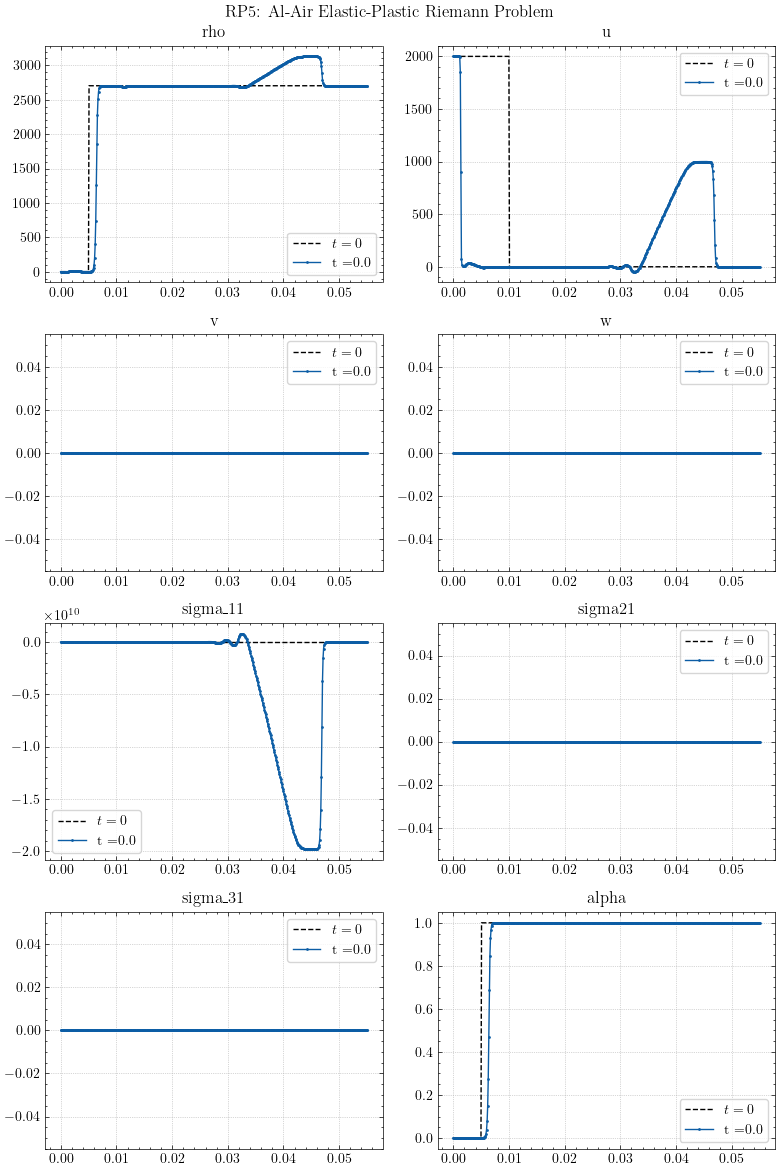

In [58]:
case = 4
ng = 4

# constant dt
if (case==0):
  case_name = "Solid-Solid advection"
  t_end = real(0.5e-4)
  dt = real(1e-6)
  
  nx = 100
  lxs=real( 0.0)
  lxe=real( 1.0)
  
  isFluid = np.array([False,False])
  Gamma0 = np.array([1.48398,2.0])
  e0     = np.array([0.,0.])
  p0     = np.array([0.,0.])
  G0     = np.array([26.36271e9,39.3813e9])
  K0     = np.array([76.3e9,136.4504e9])
  rho0   = np.array([2703.,8930.])
  C1     = np.array([0.627354,1.0])
  C2     = np.array([2.28816,3.0])
  sigmaY = np.array([1e50,1e50]) # no plastic deformation

  cls = closures(isFluid,Gamma0,e0,p0,G0,K0,rho0,C1,C2,sigmaY) 
elif (case==1):
  case_name = "Single Solid Riemann problem"
  t_end = real(0.5e-4)
  dt = real(1e-6)
  
  nx = 100
  lxs=real( 0.0)
  lxe=real( 1.0)
  
  isFluid = np.array([False,False])
  Gamma0 = np.array([1.48398,2.0])
  e0     = np.array([0.,0.])
  p0     = np.array([0.,0.])
  G0     = np.array([26.36271e9,39.3813e9])
  K0     = np.array([76.3e9,136.4504e9])
  rho0   = np.array([2703.,8930.])
  C1     = np.array([0.627354,1.0])
  C2     = np.array([2.28816,3.0])
  sigmaY = np.array([1e50,1e50]) # no plastic deformation

  cls = closures(isFluid,Gamma0,e0,p0,G0,K0,rho0,C1,C2,sigmaY) 
elif (case==2):
  case_name = "Water-Air Riemann Problem (wallis)"
  nx = 100
  lxs=real( 0.0)
  lxe=real( 1.0)

  t_end = real(237.44e-6)
  dt = real(0.0000023744)
  
  isFluid = np.array([True,True])
  gamma  = np.array([4.4,1.4])
  Gamma0 = gamma - 1.0
  
  e0     = np.array([617,0.0])
  p0     = np.array([-0.6*gamma[0]*1e9,0.0])  #--> leads to pref
  
  #need to be filled but not used
  G0     = np.array([0.0,0.0])
  K0     = np.array([0.0,0.0])
  rho0   = np.array([0.0,0.0])
  C1     = np.array([0.0,0.0])
  C2     = np.array([0.0,0.0])
  sigmaY = np.array([0.0,0.0])

  cls = closures(isFluid,Gamma0,e0,p0,G0,K0,rho0,C1,C2)  
elif (case==3):
  case_name = "Al-Cu Elastic Riemann Problem"
  t_end = real(0.5e-6)
  dt = real(5e-9)/2
  
  nx = 200
  lxs=real( 0.0)
  lxe=real( 0.01)
  
  isFluid= np.array([False,False])
  Gamma0 = np.array([1.48398,2.0])
  G0     = np.array([26.36271e9,39.3813e9])
  K0     = np.array([76.3e9,136.4504e9])
  rho0   = np.array([2703.,8930.])
  C1     = np.array([0.627354,1.0])
  C2     = np.array([2.28816,3.0])
  sigmaY = np.array([1e50,1e50]) # no plastic deformation
  
  # need to be filled but not used
  e0     = np.array([0.0,0.0])
  p0     = np.array([0.0,0.0])

  cls = closures(isFluid,Gamma0,e0,p0,G0,K0,rho0,C1,C2,sigmaY)
elif (case==4):
  case_name = "Al-Air Elastic-Plastic Riemann Problem"
  t_end = real(5e-6)
  dt = real(5e-9)*2
  
  nx = 550
  lxs=real( 0.0)
  lxe=real( 0.055)
  
  isFluid= np.array([False,True])
  e0     = np.array([0.0,0.0])
  p0     = np.array([0.0,0.0])
  Gamma0 = np.array([1.48398,0.4])
  G0     = np.array([26.36271e9,0.0])
  K0     = np.array([76.3e9,0.0])
  rho0   = np.array([2703.,0.0])
  C1     = np.array([0.627354,0.0])
  C2     = np.array([-1.,0.0])
  sigmaY = np.array([297e6, 0.0])


  cls = closures(isFluid,Gamma0,e0,p0,G0,K0,rho0,C1,C2,sigmaY)
else:
  ValueError('case does not exist')

# print(case_name)
dx = (lxe-lxs)/nx
x = np.linspace(lxs-dx/2, lxe+dx/2, nx, dtype=real)
Q = riemann_ic(x,cls.nvar,case, cls)


nvar_plt = 8
idx_plt  = [cls.imass,cls.imom,cls.ienergy,cls.ialpha]
fig, axes = plt.subplots(4,2)
fig.set_size_inches([8,12])
fig.suptitle('RP' + str(case+1) + ': ' + case_name)#, fontsize=16)
  
options = {'linestyle':'--','color':'black','label':r'$t = 0$'}
plot(0,axes,Q,x,options,cls)


nt_max = int(t_end/dt)
time = 0
for i in range(nt_max):
  lambda_max=-1e-10
  for ii in range(Q.shape[0]):
    L = np.abs(lambdas(Q[ii,:],cls))
    lambda_max = np.max([np.max(L),lambda_max])
  
  CFL = lambda_max * dt/dx
  if (CFL>1.0 or np.isnan(CFL) or CFL<0.0): 
    ValueError("CFL wrong")
  print("iter=",i+1, "/",nt_max,"  dt=",np.round(dt,12), "  dx=", np.round(dx,12),
        "  Lmax=", np.round(lambda_max,0), "  CFL=",np.round(CFL,4), end='\r' ) 
  
  # try:
  Q = rk3(Q, dx, dt, ng, cls, bc_type="FOExtrap")
  Q = ensure_symm_uni_modular_stretch_tensor(Q,cls)
  
  # if any(not cls.isFluid): Q = plastic_update(Q,ng,dt,cls)
  # except:
  #   break
  # if (i==4): break
  
  time = dt+time
  
options = {'linestyle':'-','label':r't =' + str(np.round(time,3)),'marker':'o', 'markersize':'1', 'markerfacecolor':'None'}
plot(i,axes,Q,x,options,cls)

plt.tight_layout()
# plt.savefig('./RP_AD'+str(case+1)+'.pdf',dpi=600,format="pdf", bbox_inches="tight")
# plt.savefig('./RP'+str(case+1)+'.png',dpi=600,format="png", bbox_inches="tight"case = 1